In [1]:
# Import all the necessary libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment import vader
from collections import Counter
from wordcloud import WordCloud
import datetime
from nltk import ngrams
from nltk.probability import FreqDist
import nltk.collocations as collocations
from nltk import FreqDist, bigrams
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/qatar-airways"
pages = 23
page_size = 100

reviews = []
date = []

for i in range(1, pages + 1):
    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')

    for review in parsed_content.find_all("article", {"itemprop": "review"}):
        # Extract review text
        review_text = review.find("div", {"class": "text_content"}).get_text()
        reviews.append(review_text)

        # Extract date
        try:
            review_date = review.find("div", {"class": "body"}).find("time").get_text()
        except AttributeError:
            review_date = "N/A"
        date.append(review_date)

    print(f"   ---> {len(reviews)} total reviews")


Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews
Scraping page 16
   ---> 1600 total reviews
Scraping page 17
   ---> 1700 total reviews
Scraping page 18
   ---> 1800 total reviews
Scraping page 19
   ---> 1900 total reviews
Scraping page 20
   ---> 2000 total reviews
Scraping page 21
   ---> 2100 total reviews
Scraping page 22
   ---> 2200 total reviews
Scraping page 23
   ---> 2223 total reviews


In [3]:
df = pd.DataFrame({"reviews":reviews, "date":date})
df.head()

,reviews,date
0,Not Verified | Every time the food was disgust...,23rd June 2023
1,✅ Trip Verified | Frankfurt Terminal 2 checki...,21st June 2023
2,✅ Trip Verified | Flight was okay and Doha ai...,21st June 2023
3,✅ Trip Verified | Our flight was delayed 2.5 h...,16th June 2023
4,✅ Trip Verified | The seat was small. The sta...,15th June 2023


In [4]:
cwd = os.getcwd()
df.to_csv(cwd + "/data/Qatar_reviews.csv") # Saves the dataframe as a csv file in the data folder.

In [5]:
# Inspect index 0

df['reviews'].get(0)

"Not Verified | Every time the food was disgusting!! The desserts are basically yoghurt!! Seriously yogurts are desserts?? I flied from Boston to Qatar. Qatar to Dhaka and then return from Dhaka to Qatar, Qatar to Boston. Almost in every meal food was not tasty! Disgusting foods! Means Qatar does not have good food culture! The bread they provide is so hard, that even the dogs of USA will not eat! My kids couldn't eat anything from the flight. My son has autism so we signed for the DPNA code. When we checked in looked like the staffs do not even know what is that! I didn't find any special accommodation for DPNA code provided by the Qatar Airways. We had hard time making them let us take the stroller with us as we had 8 hrs transit time in Qatar! I traveled so many other airlines. Emirates is still the best. No where near them! I will give it 2 star!"

#### <b> Clean the dataset </b>

In [6]:
len(df['reviews']) # checks the length of the column "reviews"

2223

In [7]:
# Creates a new column that extracts the information on whether the trip is verified or not

df['verified'] = df.reviews.str.contains("Trip Verified")
df['verified'].value_counts(normalize=True) # Checks the percentage value of the content in this new column.


False    0.540261
True     0.459739
Name: verified, dtype: float64

In [8]:
reviews_data = df.reviews.str.strip("✅ Trip Verified |")  
corpus =[]
# Instantiate the WordNetLemmatizer

lemma = WordNetLemmatizer()

#loop through each review, remove punctuations, small case it, join it and add it to corpus
for rev in reviews_data:
    rev = re.sub('[^a-zA-Z]',' ', rev)
    rev = rev.lower()
    rev = rev.split()
    rev = [lemma.lemmatize(word) for word in rev if word not in set(stopwords.words("english"))]
    rev = " ".join(rev)
    corpus.append(rev)

In [9]:
# add the corpus to the original dataframe

df['corpus'] = corpus
df

,reviews,date,verified,corpus
0,Not Verified | Every time the food was disgust...,23rd June 2023,False,verified every time food disgusting dessert ba...
1,✅ Trip Verified | Frankfurt Terminal 2 checki...,21st June 2023,True,frankfurt terminal checkin security check swif...
2,✅ Trip Verified | Flight was okay and Doha ai...,21st June 2023,True,flight okay doha airport city nice amazing pla...
3,✅ Trip Verified | Our flight was delayed 2.5 h...,16th June 2023,True,flight delayed hour due technical difficulty m...
4,✅ Trip Verified | The seat was small. The sta...,15th June 2023,True,seat small staff nice family adult front u pla...
...,...,...,...,...
2218,Flew first class CAI-DOH on QR503 on 8th Aug 2...,12th August 2013,False,flew first class cai doh qr th aug qatar vip l...
2219,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,6th August 2013,False,mad doh dxb back boeing mad doh sector nice sp...
2220,GVA-AUH A320. Good food but after the main mea...,6th August 2013,False,gva auh good food main meal nothing else serve...
2221,I took a flight to London on 17th July with my...,6th August 2013,False,took flight london th july year old son wife t...


In [10]:
#Removing unwanted text(first text preprocessing)
df.replace(re.compile(r'\s*✅ Trip Verified \|\s*'), '', inplace=True)

df.head(8)

,reviews,date,verified,corpus
0,Not Verified | Every time the food was disgust...,23rd June 2023,False,verified every time food disgusting dessert ba...
1,Frankfurt Terminal 2 checkin and security chec...,21st June 2023,True,frankfurt terminal checkin security check swif...
2,Flight was okay and Doha airport and city both...,21st June 2023,True,flight okay doha airport city nice amazing pla...
3,Our flight was delayed 2.5 hours due to a tech...,16th June 2023,True,flight delayed hour due technical difficulty m...
4,The seat was small. The staff was very nice. T...,15th June 2023,True,seat small staff nice family adult front u pla...
5,Flight on time. Smooth cooperation with their ...,15th June 2023,True,flight time smooth cooperation partner rwandai...
6,I flew with Qatar to HKT via DOH (return via B...,14th June 2023,True,flew qatar hkt via doh return via bkk doh am u...
7,"The aircraft was very old, the screen Tv was b...",14th June 2023,True,aircraft old screen tv blurred working seat un...


In [11]:
# convert the date to datetime format

df.date = pd.to_datetime(df.date)

df.head()

,reviews,date,verified,corpus
0,Not Verified | Every time the food was disgust...,2023-06-23,False,verified every time food disgusting dessert ba...
1,Frankfurt Terminal 2 checkin and security chec...,2023-06-21,True,frankfurt terminal checkin security check swif...
2,Flight was okay and Doha airport and city both...,2023-06-21,True,flight okay doha airport city nice amazing pla...
3,Our flight was delayed 2.5 hours due to a tech...,2023-06-16,True,flight delayed hour due technical difficulty m...
4,The seat was small. The staff was very nice. T...,2023-06-15,True,seat small staff nice family adult front u pla...


In [12]:
df.isna().sum()

reviews     0
date        0
verified    0
corpus      0
dtype: int64

In [13]:
# Cleaned data 
df.to_csv( cwd + "/data/Qatar_reviews_cleaned.csv")

## <b> EDA </b>

In [14]:
# an instance of SentimentIntensityAnalyzer
sentiment_analyzer = vader.SentimentIntensityAnalyzer()

# a new column named 'sentiment'
df['sentiment'] = df['reviews'].apply(
    lambda review: sentiment_analyzer.polarity_scores(review)['compound']
    )
df

,reviews,date,verified,corpus,sentiment
0,Not Verified | Every time the food was disgust...,2023-06-23,False,verified every time food disgusting dessert ba...,-0.6955
1,Frankfurt Terminal 2 checkin and security chec...,2023-06-21,True,frankfurt terminal checkin security check swif...,0.3197
2,Flight was okay and Doha airport and city both...,2023-06-21,True,flight okay doha airport city nice amazing pla...,0.8108
3,Our flight was delayed 2.5 hours due to a tech...,2023-06-16,True,flight delayed hour due technical difficulty m...,-0.8658
4,The seat was small. The staff was very nice. T...,2023-06-15,True,seat small staff nice family adult front u pla...,0.8550
...,...,...,...,...,...
2218,Flew first class CAI-DOH on QR503 on 8th Aug 2...,2013-08-12,False,flew first class cai doh qr th aug qatar vip l...,0.9780
2219,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,2013-08-06,False,mad doh dxb back boeing mad doh sector nice sp...,-0.9092
2220,GVA-AUH A320. Good food but after the main mea...,2013-08-06,False,gva auh good food main meal nothing else serve...,0.6597
2221,I took a flight to London on 17th July with my...,2013-08-06,False,took flight london th july year old son wife t...,-0.6256


In [15]:
# Creating another new column called 'sentiment_type' that contains the type of sentiment of each review using nltk
# for each sentiment score in the 'SENTIMENT' column
df['sentiment_type'] = df['sentiment'].apply(
    lambda score: 'positive' if score > 0 else ('negative' if score < 0 else 'neutral')
    )
df #inspect the dataframe

,reviews,date,verified,corpus,sentiment,sentiment_type
0,Not Verified | Every time the food was disgust...,2023-06-23,False,verified every time food disgusting dessert ba...,-0.6955,negative
1,Frankfurt Terminal 2 checkin and security chec...,2023-06-21,True,frankfurt terminal checkin security check swif...,0.3197,positive
2,Flight was okay and Doha airport and city both...,2023-06-21,True,flight okay doha airport city nice amazing pla...,0.8108,positive
3,Our flight was delayed 2.5 hours due to a tech...,2023-06-16,True,flight delayed hour due technical difficulty m...,-0.8658,negative
4,The seat was small. The staff was very nice. T...,2023-06-15,True,seat small staff nice family adult front u pla...,0.8550,positive
...,...,...,...,...,...,...
2218,Flew first class CAI-DOH on QR503 on 8th Aug 2...,2013-08-12,False,flew first class cai doh qr th aug qatar vip l...,0.9780,positive
2219,MAD-DOH-DXB and back. Boeing 777 in MAD-DOH se...,2013-08-06,False,mad doh dxb back boeing mad doh sector nice sp...,-0.9092,negative
2220,GVA-AUH A320. Good food but after the main mea...,2013-08-06,False,gva auh good food main meal nothing else serve...,0.6597,positive
2221,I took a flight to London on 17th July with my...,2013-08-06,False,took flight london th july year old son wife t...,-0.6256,negative


In [16]:
# calculate the percentage of each type of sentiment score
sent_type_percentages = df['sentiment_type'].value_counts(normalize=True)
sent_type_percentages

positive    0.802969
negative    0.195232
neutral     0.001799
Name: sentiment_type, dtype: float64

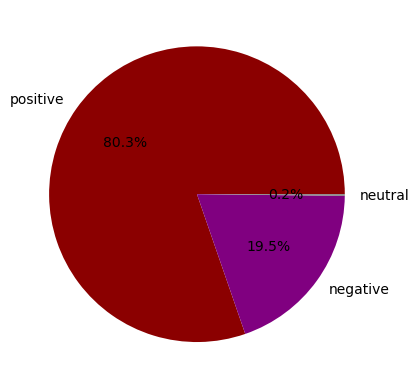

In [17]:
# Plot the sentiment percentages 

# create the pie chart
fig, ax = plt.subplots()
ax.pie(
    sent_type_percentages,
    labels=sent_type_percentages.index, 
    colors=['darkred', 'purple', 'grey'], 
    autopct='%1.1f%%'
    )

plt.show()

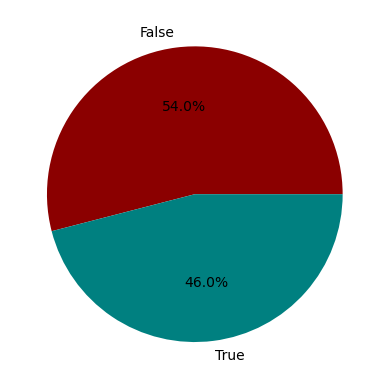

In [18]:
# Plot the verified reviews 
verified_pctg = df['verified'].value_counts(normalize=True)

# create the pie chart
fig, ax = plt.subplots()
ax.pie(
    verified_pctg,
    labels=verified_pctg.index, 
    colors=['darkred', 'teal'], 
    autopct='%1.1f%%'
    )

plt.show()

In [19]:
df.to_csv( cwd + "/data/Qatar_sentiment_analysis_data.csv")

In [20]:
# make a frequency chart that will tell us the key topics that are mentioned in the reviews

reviews = df['corpus']

# Convert the reviews into a list of words 

words = []
for review in reviews:
    words.extend(review.split())
    

# Filter out the remaining stopwords

stopwords = nltk.corpus.stopwords.words('english')
key_words = [word for word in words if word not in stopwords and word not in ['I', 'The','would','one','get','-']]


In [21]:
# Get the top 20 most used words 
word_counts = Counter(key_words)
top_20_words = word_counts.most_common(20)

# Filter out any of the remaining stop words 
filtered_words = [
    (word, count) for word, count in top_20_words if word not in stopwords and word not in ['I', 'The','would','one','get','-']
    ]


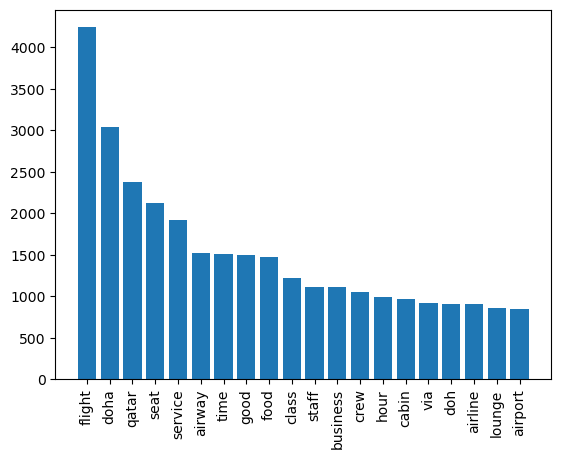

In [22]:
# Get the labels and values for the histogram
labels, values = zip(*top_20_words)

# Create the histogram
plt.bar(labels, values)

# Set the x-axis labels to be vertical
plt.xticks(rotation=90)

#Display the plot
plt.show()


## Time series analysis

In [23]:
#convert the date datatype to datetime

df.date = pd.to_datetime(df.date)
fig = px.line(df, x='date')
fig.show()

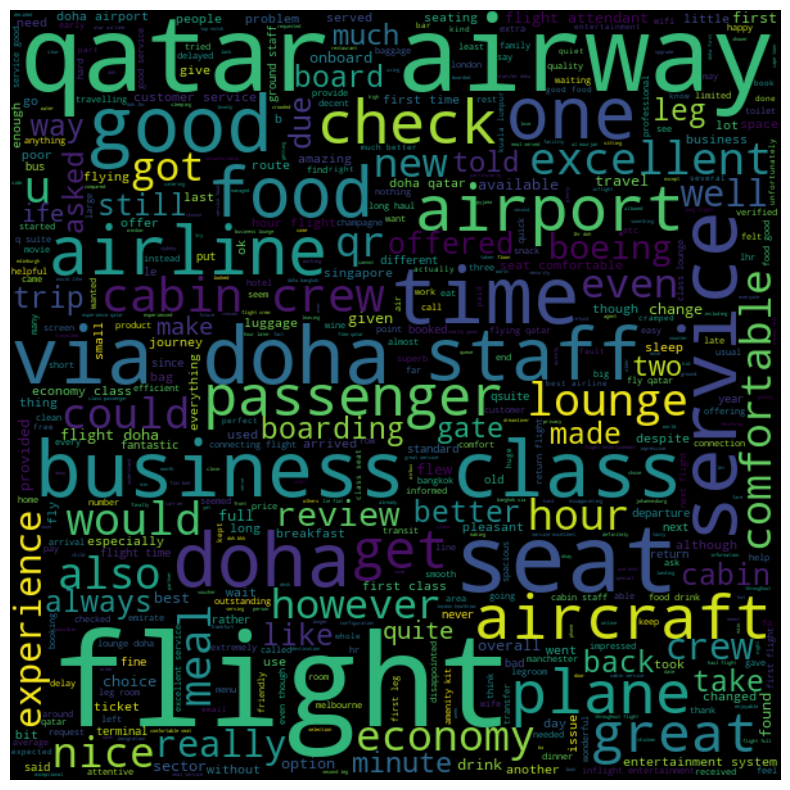

In [24]:
# Start with one review:
reviews = " ".join(df.corpus)
plt.figure(figsize=(20,10))

# Create and generate a word cloud image:
wordcloud = WordCloud(height=600,width=600,max_font_size=100, max_words=500, stopwords=stopwords).generate(reviews)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
#split the text of all reviews into a list of words
words = reviews.split(" ")

#remove certain words that will not be used to determine the positive or negative sentiment
stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'qatar', "passenger","u","airway","airline", "aircraft",
                                           "doha","plane","via","new", "qr"])


new_words = [word for word in words if word not in stopwords]

nlp_words=FreqDist(new_words).most_common(20)

#create a dataframe of these word and its frequencies
all_fdist = pd.Series(dict(nlp_words))

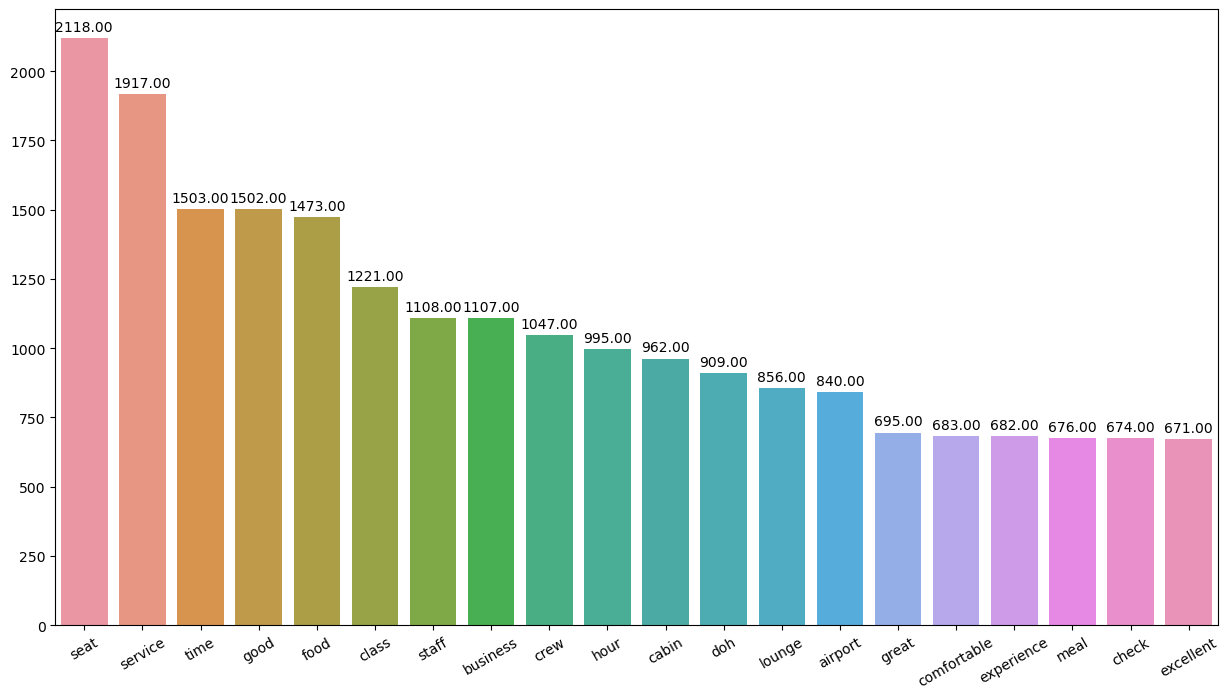

In [26]:
# Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(15, 8))

# Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)

# Add labels to the bars
for container in all_plot.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points',
                    ha='center', va='bottom')

# Rotate x-axis tick labels for better visibility
plt.xticks(rotation=30)

# Display the plot
plt.show()

### <b> Word Frequency using N-gram </b>

<AxesSubplot:>

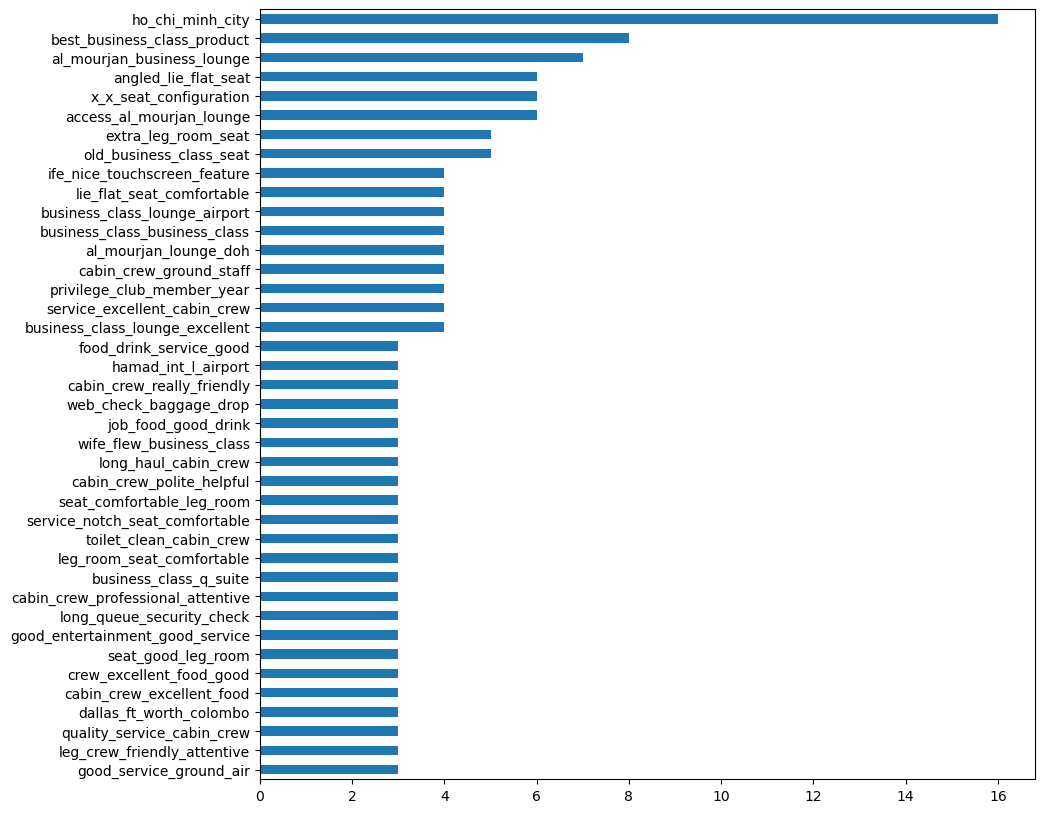

In [27]:
reviews = " ".join(df.corpus)

# Split the text of all reviews into a list of words
words = reviews.split(" ")

new_words = [word for word in words if word not in stopwords]

def get_freq_dist(new_words, number_of_ngrams):
    # Generate n-grams
    ngrams_list = list(ngrams(new_words, number_of_ngrams))

    # Creating FreqDist
    ngram_fd = FreqDist(ngrams_list).most_common(40)

    # Sort values by highest frequency
    ngram_sorted = {k: v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Join n-gram tokens with '_' and maintain sorting
    ngram_joined = {'_'.join(k): v for k, v in sorted(ngram_fd, key=lambda item: item[1])}

    # Convert to Pandas Series for easy plotting
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10, 10))
    ax = ngram_freqdist.plot(kind="barh")

    return ax

get_freq_dist(new_words, 4)


In [28]:
%%capture
vds = SentimentIntensityAnalyzer()
# text = 'This is an extremely entertaining movie'

#set a column Polarity with all 0 values initially
df['label'] = 0
    
for i in range(len(df.corpus)):
    
    score = vds.polarity_scores(df.corpus[i])['compound']
    #print(score)
    if score > 0.2:
        df['label'][i] = 1
        #print("1st")
    elif score < 0:
        df['label'][i] = -1
        #print("2nd")
    else:
        df['label'][i] = 0


In [29]:
df.label.value_counts()


 1    1834
-1     324
 0      65
Name: label, dtype: int64

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

# Create an object of CountVectorizer
vect = CountVectorizer()

# Convert the corpus to a list of strings (if not already)
corpus = df.corpus.tolist()

# Apply transformation
tf = vect.fit_transform(corpus)
tf_array = tf.toarray()

# Get the feature names
tf_feature_names = vect.get_feature_names_out()

In [31]:
#declare the number of topics
number_of_topics = 8

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit the term frequency data to the model
model.fit(tf)

#create empty dictionary to store key value pair of topic number and its weights
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(model.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic = pd.DataFrame(topic_dict)

df_topic
### <b> Topic modeling with NMF
nmf = NMF(n_components=2, init='random', random_state=0)
nmf.fit_transform(tf)

array([[0.08074071, 0.11884081],
       [0.05543038, 0.043654  ],
       [0.06420107, 0.03081683],
       ...,
       [0.04179509, 0.05378519],
       [0.06917017, 0.0116443 ],
       [0.09570693, 0.10366474]])

In [32]:
topic_dict = {}

#loop through model components 
for topic_idx, topic in enumerate(nmf.components_):
    topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(tf_feature_names[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
            for i in topic.argsort()[:-10 - 1:-1]]
    
df_topic =pd.DataFrame(topic_dict)

df_topic

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights
0,flight,28.5,seat,8.9
1,doha,10.4,service,5.8
2,qatar,8.8,class,5.7
3,hour,6.7,good,5.6
4,airway,5.7,business,5.4
5,time,5.2,doha,5.3
6,airport,4.3,food,4.9
7,staff,3.9,lounge,4.2
8,would,3.3,doh,3.8
9,via,2.8,qatar,3.8
